### Imports and set up

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import itertools

#torch imports 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.metrics import accuracy_score
from torcheeg.models.gnn.dgcnn import GraphConvolution
# helper sctipts 
import utils.graph_utils as gu
import utils.data_utils as du
import utils.model_utils as mu 
import utils.visual_utils as vu
from utils.model_utils import TrainNN
from utils.cka import CKACalculator

# tracking 
import wandb

## Path constants
path="artifacts"
modelname="dgcnn_mod"
data_path = "../data/"
preprocessed_data_path = f"{path}/preprocessed_data.npy"
has_val_set = False
seed = 42

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')
bands = {"delta": [1, 4],"theta": [4, 8],"alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}

## Read metadata dataframeimports
metadata = pd.read_csv(data_path + 'sample_metadata.tsv', sep='\t')

In [2]:
# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

In [3]:
X_bde = du.band_preprocess(X, preprocessed_data_path)     

### Split data into train, validation and test sets

In [4]:
if has_val_set:
    X_train, y_train, X_val, y_val, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_val.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_val.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    
    nsamples_val, nchannels_val, bands = X_val.shape
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    
else:
    X_train, y_train, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"

assert X_train.shape[1]==X.shape[1],"Preprossed data lost channels"
assert X_train.shape[2]==len(bands),"Preprossed data does have incorrect amount of bands"

nsamples_train, nchannels_train, bands = X_train.shape
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Training & model hyperparameters

## Train model
### Train 4 models and calculate CKA matrices for pairs of models
## Functions to get activations of a layer type and calculated adjacency matrix

In [5]:
wandb.login()
def train_models(model,modeltrainer,hid_chans,num_models=1,new =False, prints=False):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    mods = []
    for i in range(num_models):
        
        tmp_mod = model(in_channels=num_chans, num_electrodes=num_electrodes, 
                              hid_channels=hid_chans, num_layers=num_layers, num_classes=num_outputs)
        model_path=f"{path}/{modelname}_chan{hid_chans}_{i}.pth"
        print(f"Model {i+1}")
        if new or not os.path.exists(model_path):    
            if not os.path.exists(model_path) and not new:
                print(f"Could not resolve path: {model_path}")
                new_models=True
            trainer = modeltrainer()
            
            if has_val_set:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=f"{modelname}_chan{hid_chans}",
                            has_val_set=has_val_set,val_loader=val_loader,w_decay=w_decay,epochs=epochs, 
                            prints=prints, modrun=i))
            else:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=f"{modelname}_chan{hid_chans}",
                                                has_val_set=has_val_set,val_loader=None,w_decay=w_decay,epochs=epochs, 
                                                prints=prints, modrun=i))   
        else: 
            tmp_mod.load_state_dict(torch.load(model_path))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])
    return mods

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lili-raleva (braincells) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
# Model parameters
num_chans = 5
num_electrodes = 22
num_outputs = y.max().item() + 1
num_layers = 2
hid_chans = 16

# Training parameters
lr = 1e-4
epochs = 40
w_decay = 1e-3

#Models 
modruns = 4
plot=True
new_models=False
mods = train_models(DGCNN, TrainNN,hid_chans,num_models=modruns, prints=plot, new=new_models)

Model 1
Model 2
Model 3
Model 4


In [8]:
def multi_parameter_mod(param_list, seed_list, n_models):
    
    # TO DO: take into account seeds. Right now the seed_list doesn't do anything
    
    # all combinations of model indexes (excluding duplicates & same model with same model)
    combs = [(i, j) for i in range(0, n_models) for j in range(i+1, n_models)]
    
    # dicts containing models, barycenters, simrank similarities and edit distances of models
    # with same number of hidden neurons
    # ie dicts with all "parameter internal" metrics
    models_dict = dict([(x, []) for x in param_list])
    bary_dict = dict([(x, []) for x in param_list])
    sim_dict = dict([(x, []) for x in param_list])
    edit_dists_internal = dict([(x, []) for x in param_list])
    
    # all combinations of model indexes between two parameter sets
    # ex all model combinations between models with 8 hidden neurons and models with 16 hidden neurons
    combs_external = list(itertools.product([x for x in range(n_models)], [x+n_models for x in range(n_models)]))
    
    # all combinations of parameter values, in this case number of hidden neurons
    param_combs = [(param_list[i], param_list[j]) for i in range(0, len(param_list)) for j in range(i+1, len(param_list))]
    
    # dict containing edit distances between each pair of models between each pair of parameters
    edit_dists_external = dict([(x, []) for x in param_combs])
    
    # train n_models models with each number of hidden neurons specified in the param_list
    for n_chans in param_list:
        
        curr_model = [x[0] for x in train_models(DGCNN, TrainNN, n_chans, num_models = n_models, prints=plot, new=False)]
        models_dict[n_chans].extend(curr_model)
    
    # calculate all metrics for models with the same number of hidden neurons
    for n_chans in param_list:
        models = models_dict[n_chans]
        bary, sim, _, ed = gu.get_graph_metrics(models, prints=False)
        bary_dict[n_chans].extend(bary)
        sim_dict[n_chans].extend(sim)
        edit_dists_internal[n_chans].extend(ed)
    
    # calculate edit distance between models with different number of hidden neurons
    for param_comb in param_combs:
        for ext_comb in combs_external:
            model1_idx = ext_comb[0]; model2_idx = ext_comb[1]
            model1 = models_dict[param_comb[0]][model1_idx]
            model2 = models_dict[param_comb[1]][model2_idx-n_models]
            G1 = gu.make_graph(mu.get_adj_mat(model1))
            G2 = gu.make_graph(mu.get_adj_mat(model2))
            ed_external = next(nx.optimize_graph_edit_distance(G1, G2))
            edit_dists_external[param_comb].append(ed_external)

    return models_dict, bary_dict, sim_dict, edit_dists_internal, edit_dists_external

In [9]:
param_list = [8, 16, 24]
seed_list = [42]
n_models = 4

models, barycenters, sims, edit_dists_internal, edit_dists_external = multi_parameter_mod(param_list, seed_list, n_models)

Model 1
Model 2
Model 3
Model 4
Model 1
Model 2
Model 3
Model 4
Model 1
Model 2
Model 3
Model 4


Model 1 test
Acc train: 0.6619242826139378
Acc test: 0.46962391513982643
F1 train: 0.6619381600820174
F1 test: 0.4681900014058159


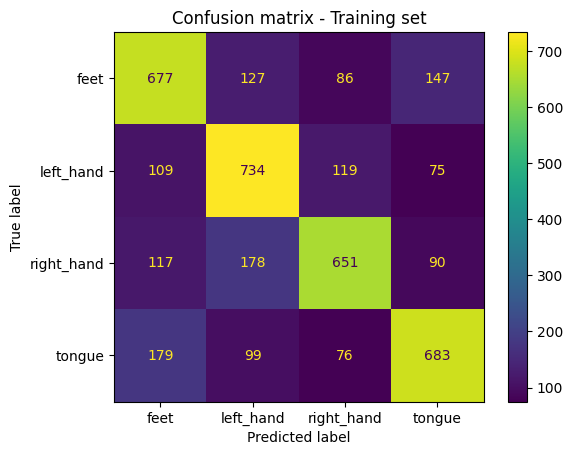

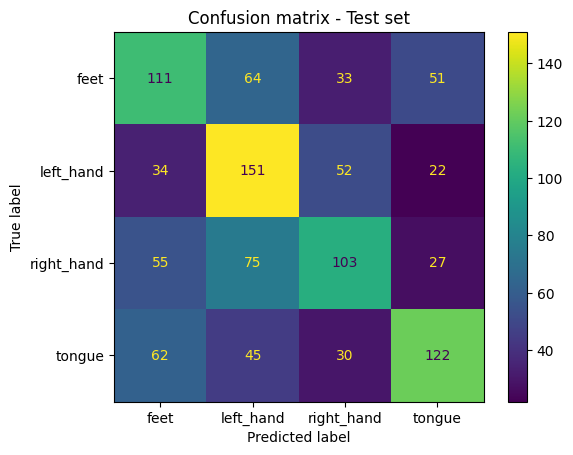

Model 2 test
Acc train: 0.6807330600434048
Acc test: 0.4927675988428158
F1 train: 0.6804490226820133
F1 test: 0.49148422320420654


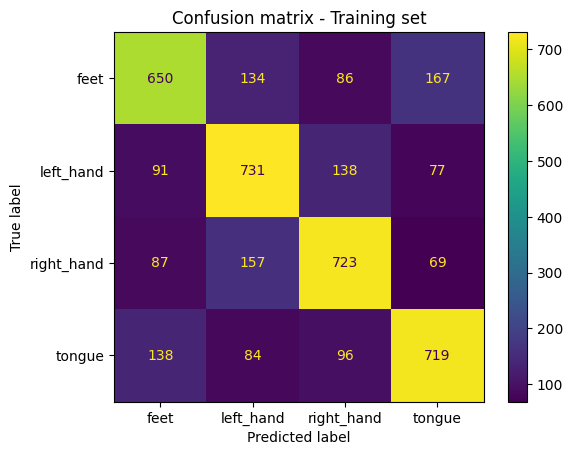

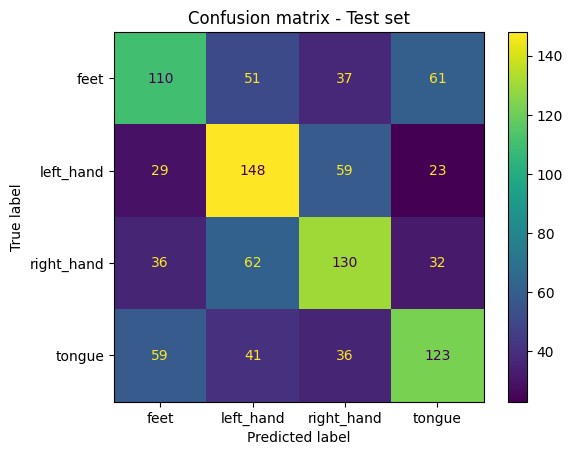

Model 3 test
Acc train: 0.6197251024837231
Acc test: 0.4869816779170685
F1 train: 0.618481347769356
F1 test: 0.4842121730319174


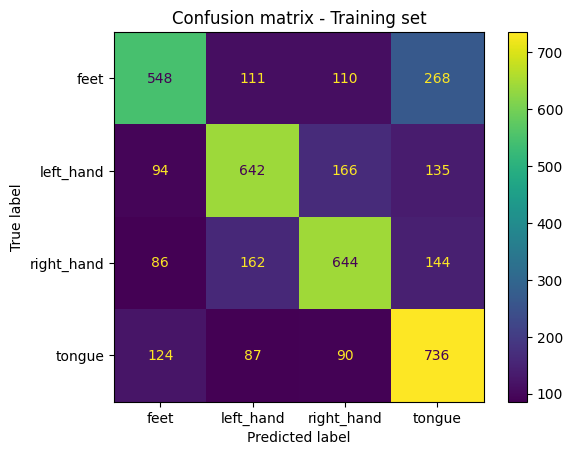

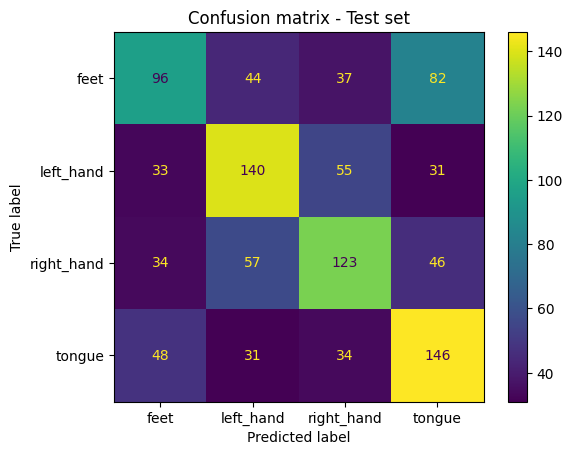

Model 4 test
Acc train: 0.6542078611044129
Acc test: 0.48987463837994216
F1 train: 0.6544909527210035
F1 test: 0.4903270169402877


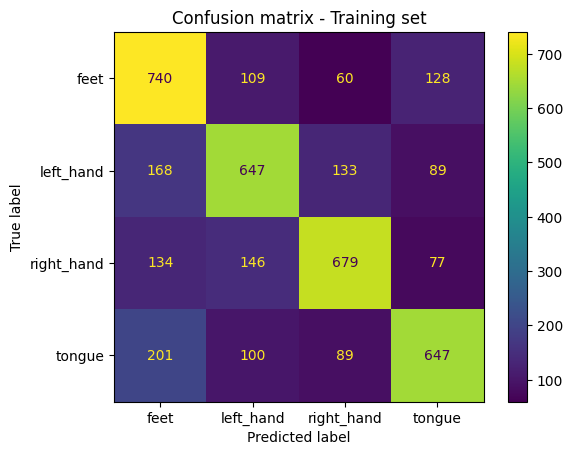

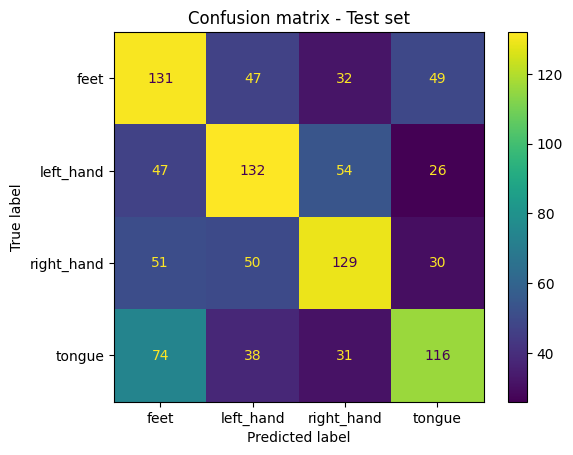

In [14]:
for i in range(modruns):
    print(f"Model {i+1} test")
    test_model = mods[i][0].to("cpu").eval()
    mu.model_metrics(test_model, X_train, y_train, X_test, y_test, None, None,plots=plot)

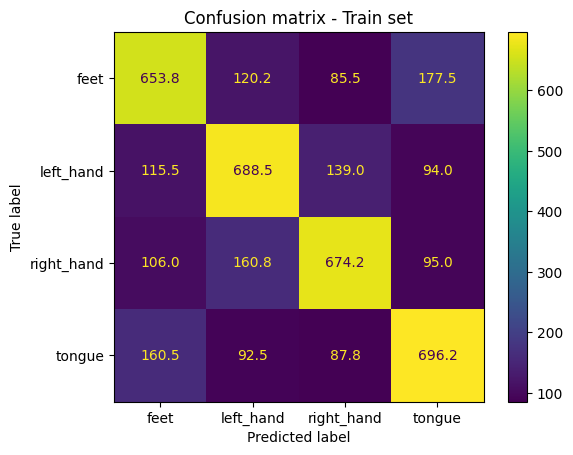

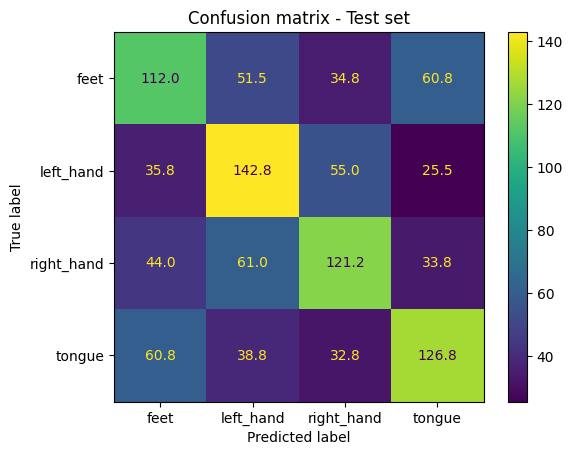

(array([[653.75, 120.25,  85.5 , 177.5 ],
        [115.5 , 688.5 , 139.  ,  94.  ],
        [106.  , 160.75, 674.25,  95.  ],
        [160.5 ,  92.5 ,  87.75, 696.25]]),
 array([[112.  ,  51.5 ,  34.75,  60.75],
        [ 35.75, 142.75,  55.  ,  25.5 ],
        [ 44.  ,  61.  , 121.25,  33.75],
        [ 60.75,  38.75,  32.75, 126.75]]))

In [15]:
mu.confusiong_avg(mods,X_train, y_train, X_test, y_test,plots=True)

## Graphs


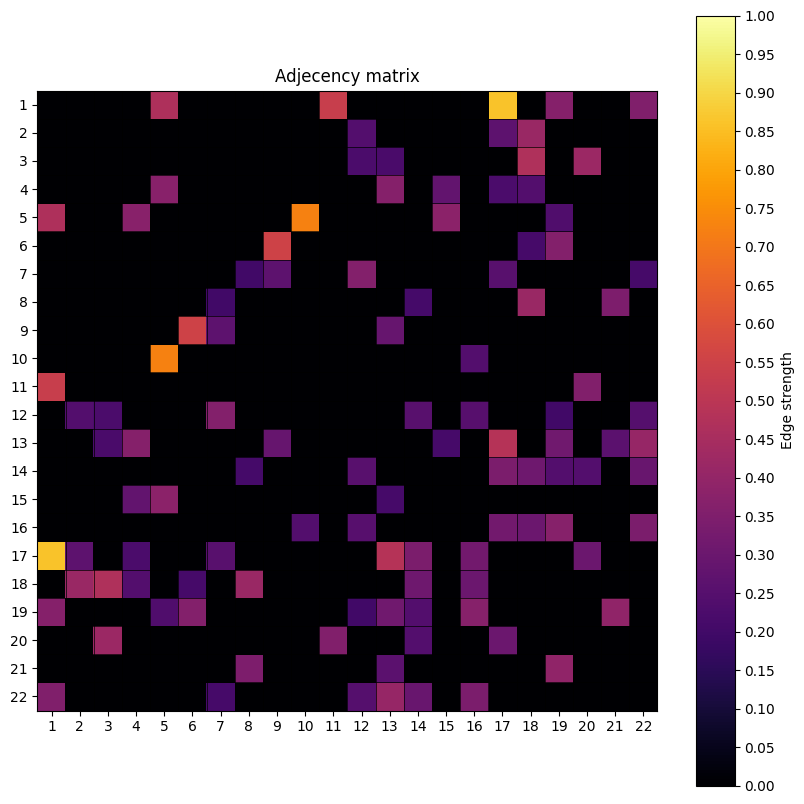

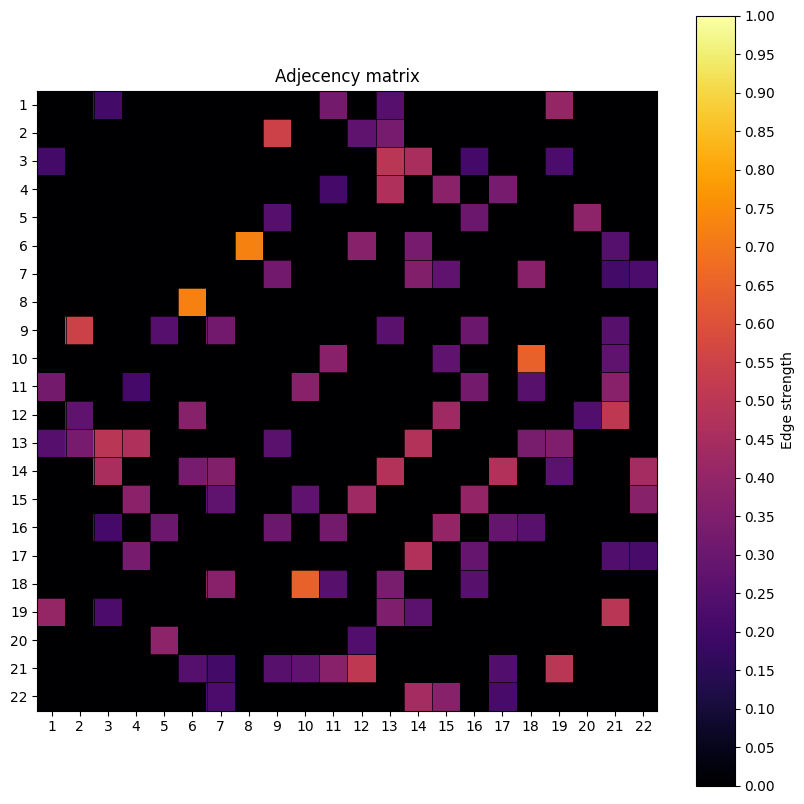

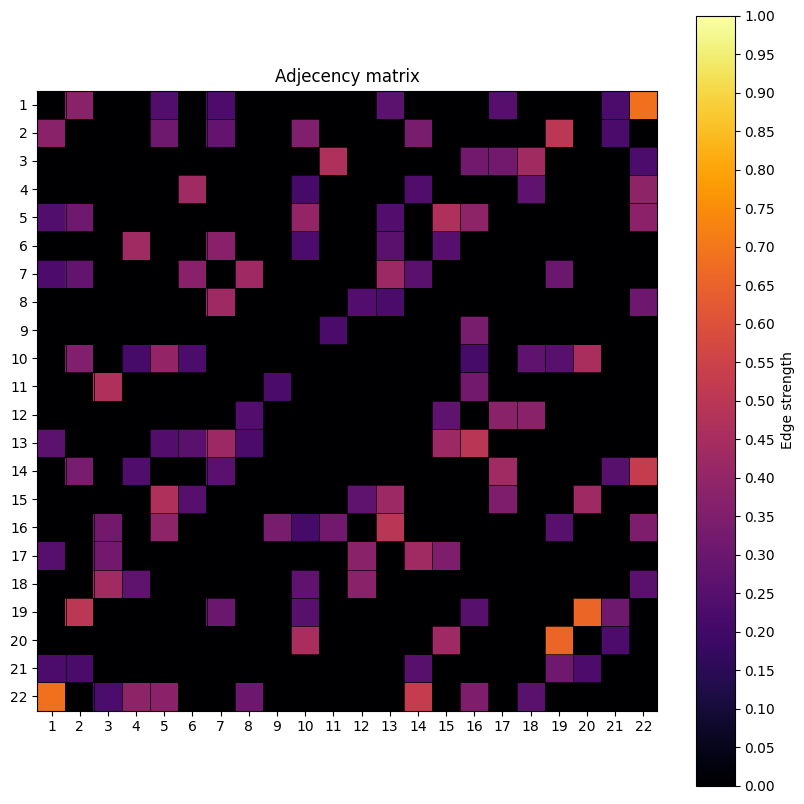

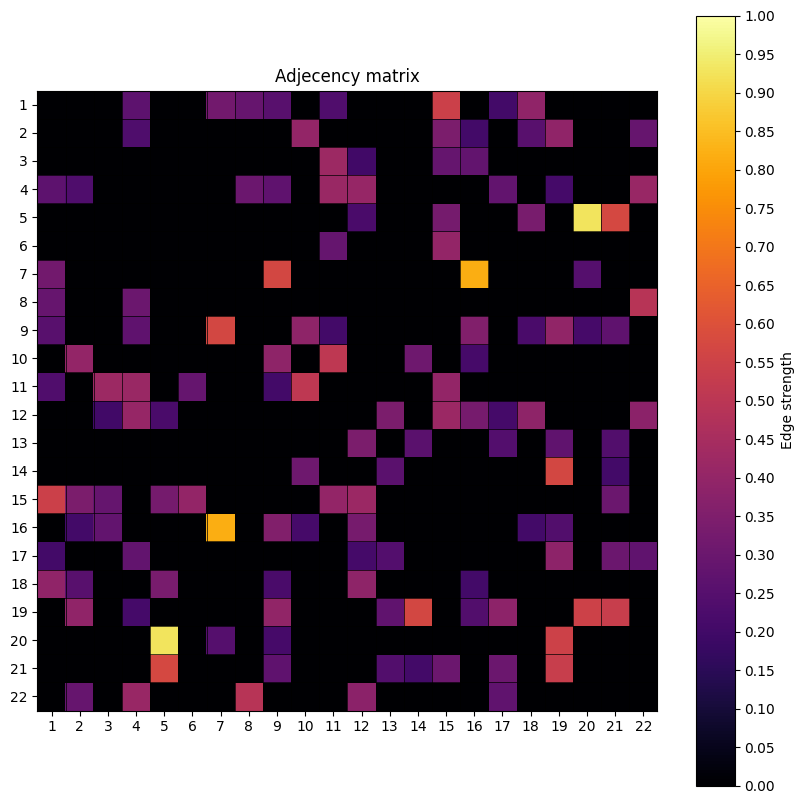

In [16]:
graphs=[]
adj_mats=[]
for i in range(modruns):
    adj_mats.append(mu.get_adj_mat(mods[i][0]))
    graphs.append(gu.make_graph(adj_mats[i]))
if plot:
    for adj in adj_mats:
        vu.visualize_adj_mat(adj)
#throw error if isomophic
for G1 in range(len(mods)):
    for G2 in range(G1+1,len(mods)):
        assert gu.check_not_isomorphism(graphs[G1],graphs[G2]), f"Graph G{G1} and G{G2} are isomophic"

In [17]:
if plot:
    vu.graph_plot(adj_mats,vu.graph_visual,2,2, barycenters)

KeyError: 0

<Figure size 1000x1000 with 0 Axes>

In [ ]:
bi_g, bi_adj = gu.make_binary_graph(adj_mats[2],thresh=0.3)
if plot:
    vu.visualize_adj_mat(bi_adj)
    vu.graph_plot([bi_adj],vu.graph_visual,1,1,barycenters)

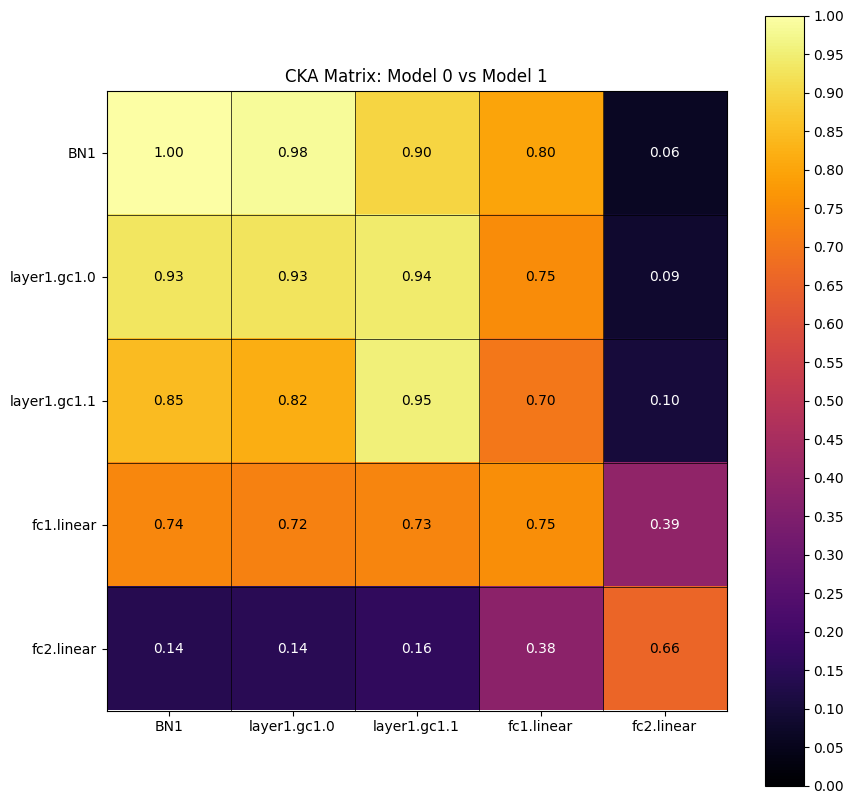

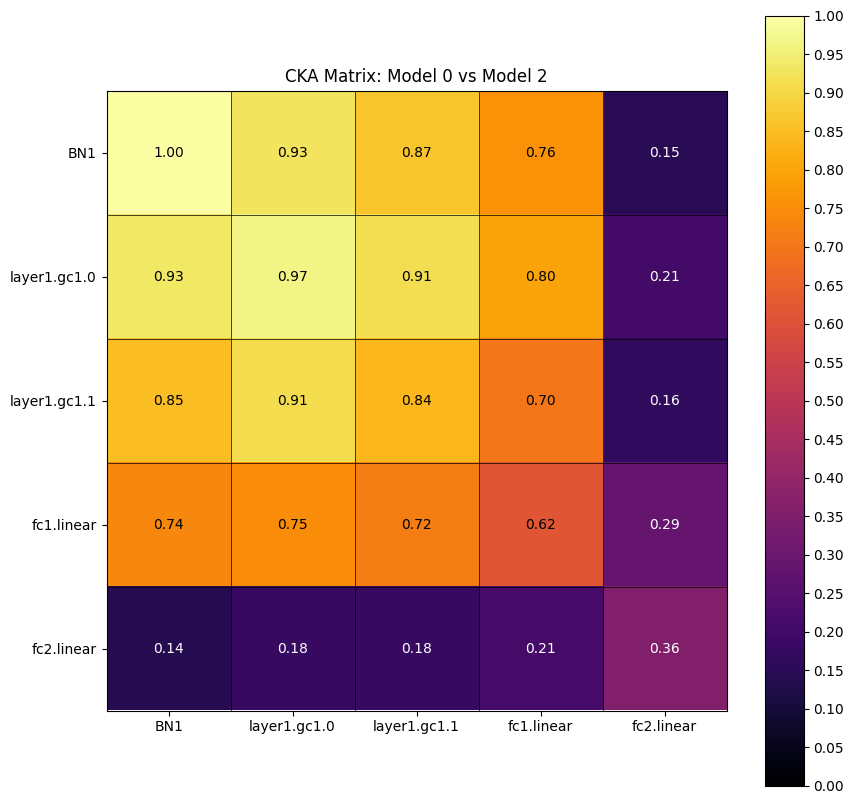

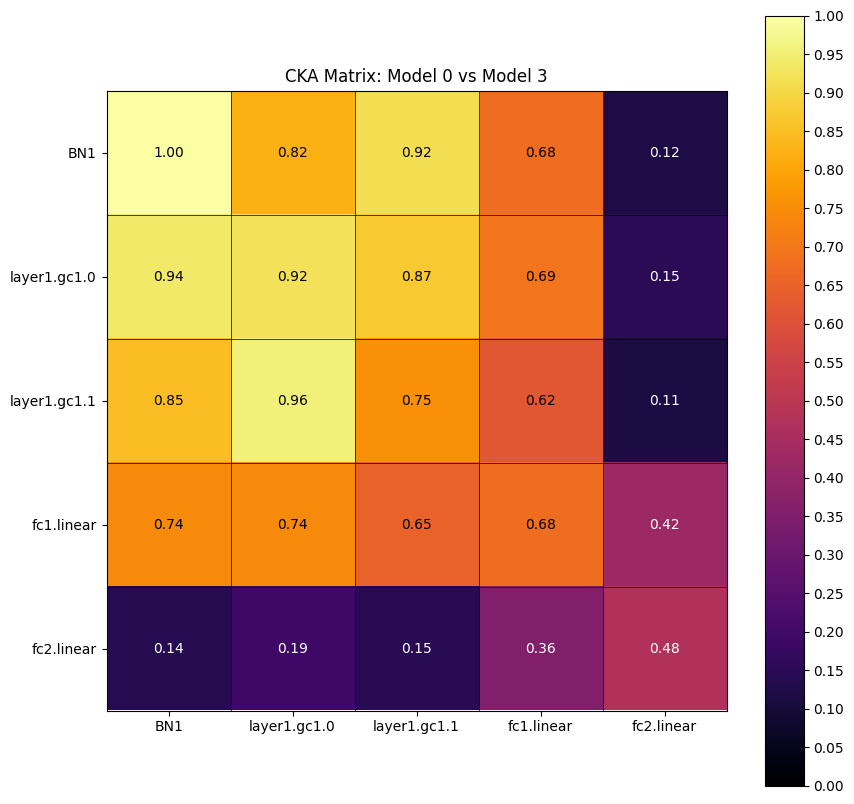

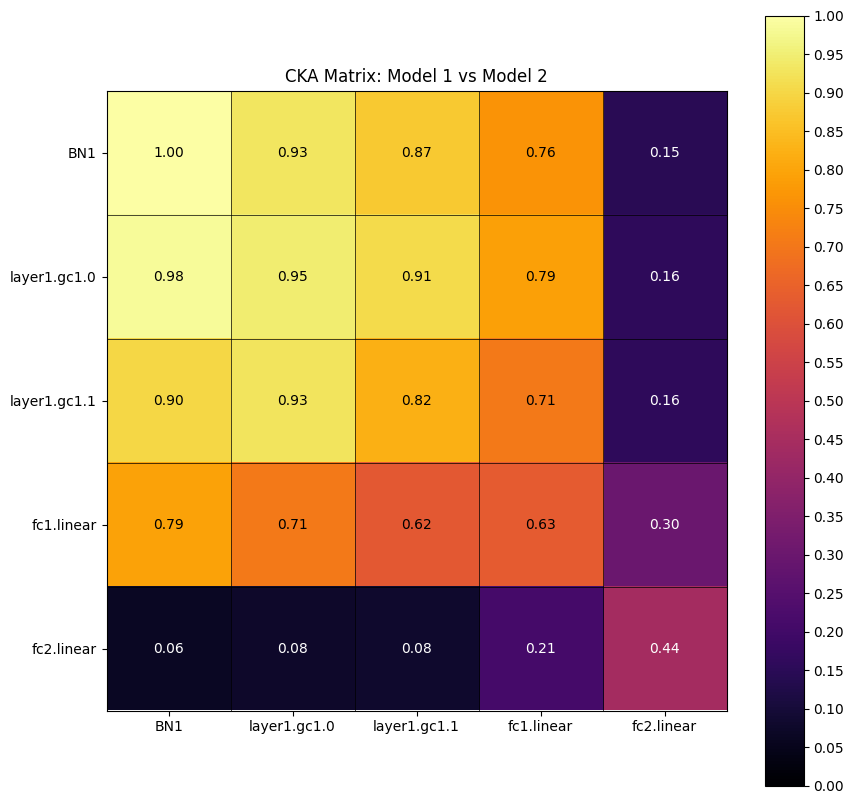

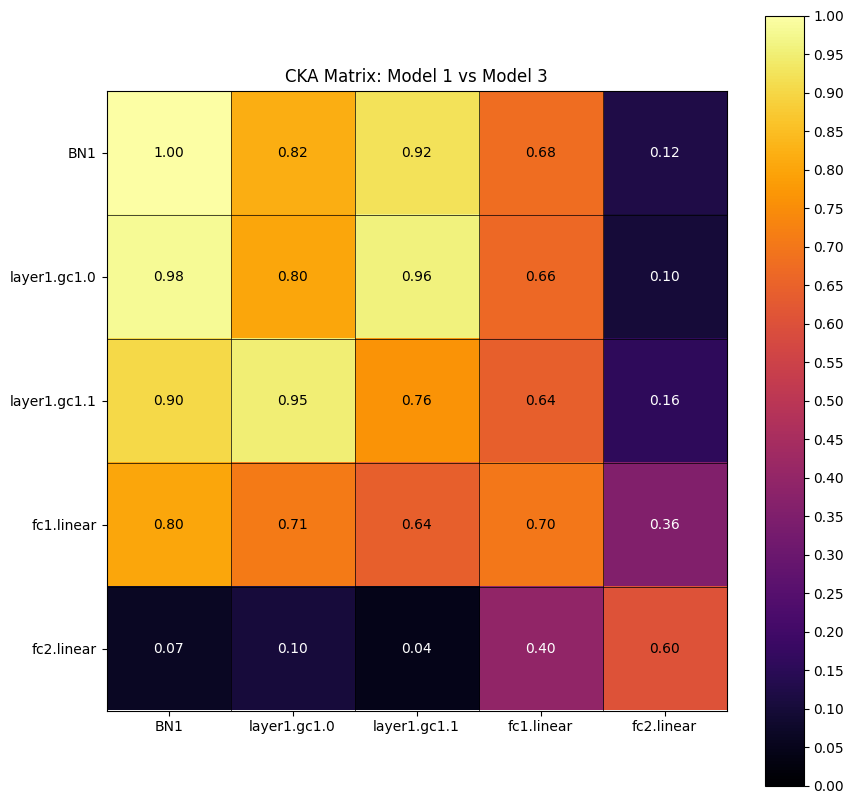

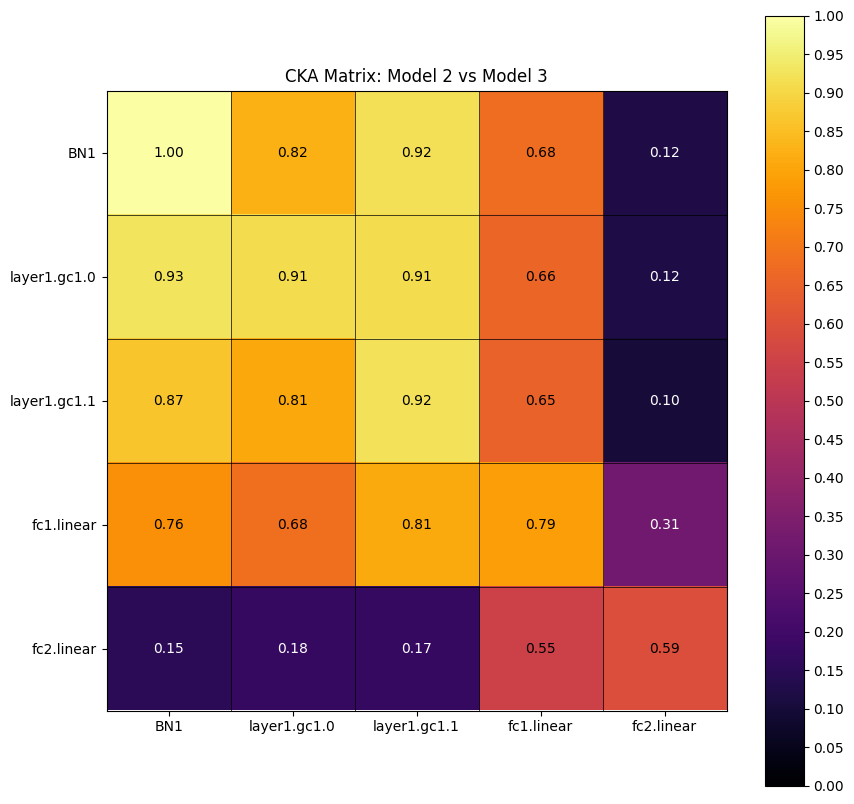

In [18]:
cka_all = []
for i in range(modruns-1):
    for j in range(i+1,modruns):
        calculator = CKACalculator(model1=mods[i][0], model2=mods[j][0], 
                                dataloader=train_loader,
                                layers_to_hook=(nn.Conv2d, nn.Linear,
                                     nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
        cka_output = calculator.calculate_cka_matrix(train_dataset)
        #calculator.test_cka(10,train_dataset)
        cka_all.append(cka_output)
        if plot:
            vu.plot_matrix(f'CKA Matrix: Model {i} vs Model {j}'
                          ,cka_output.cpu().numpy(),calculator.module_names_X,
                           calculator.module_names_Y)

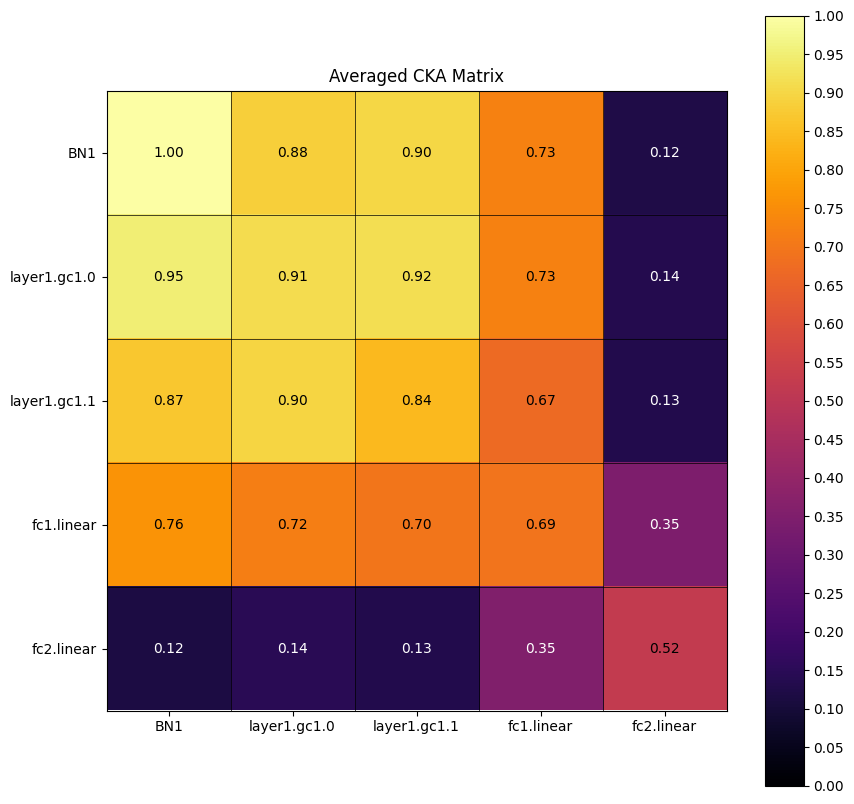

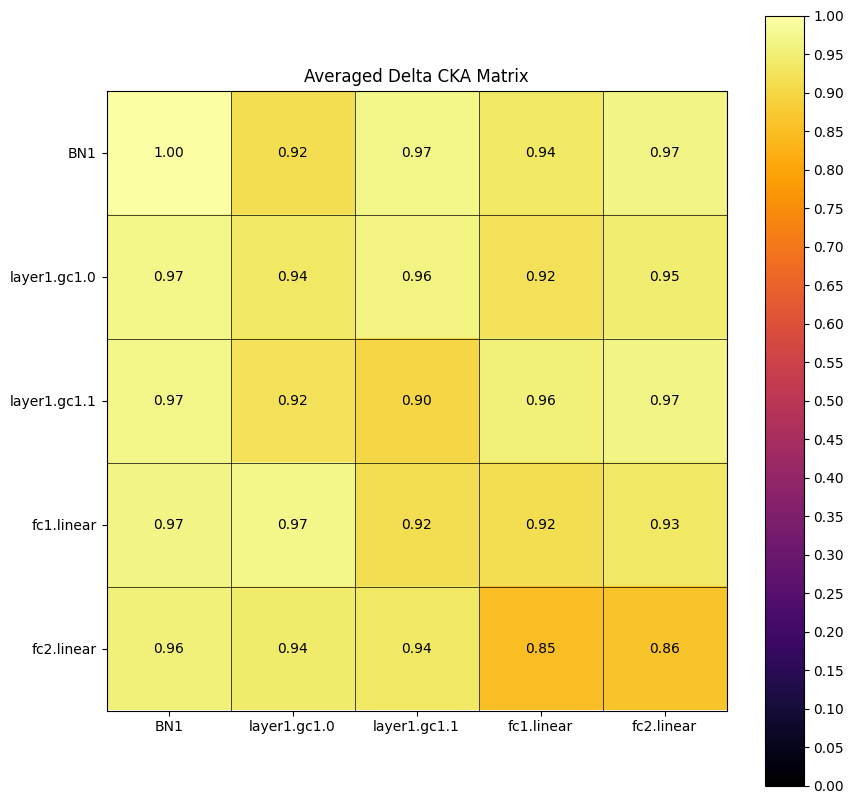

In [19]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []

for i in range(len(cka_stack)):
    for j in range(i+1,len(cka_stack)):
        delta_matrices.append(torch.abs(cka_stack[i] - cka_stack[j])) 
        
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix = 1- delta_matrices.mean(dim=0)  
if plot:
    vu.plot_matrix("Averaged CKA Matrix",average_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)
    vu.plot_matrix("Averaged Delta CKA Matrix",average_delta_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

In [ ]:
if has_val_set:

    for i  in range (len(mods)):
        filepath=f"{path}/Training_validation_loss{i}.npy"
        if not new_models:
            try: 
                with open(filepath, "rb") as f:
                    data = np.load(f)
            except:
                print(f"File with the data could not be found looking at address: {filepath}")
        else:
            with open(filepath, "wb") as f:
                np.save(f, mods[0][1])
                data = mods[0][1]
        plt.plot(data[0])
        plt.plot(data[1])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["training loss","validation loss"])
        plt.title(f"Model{i} Training vs validation loss")
        plt.show()
    